In [3]:

!uv pip install openai hcaptcha_challenger --link-mode=copy

Using Python 3.12.9 environment at: D:\_GitHubProjects\Sources\hcaptcha-challenger\.venv
Audited 1 package in 4ms


In [19]:
import base64
import os
from pathlib import Path

import dotenv
from IPython.display import JSON, Image
from matplotlib import pyplot as plt
from openai import OpenAI

from hcaptcha_challenger import ChallengeTypeEnum
from hcaptcha_challenger.helper import FloatRect, create_coordinate_grid
from hcaptcha_challenger.helper.visualize_attention_points import show_answer_points
from hcaptcha_challenger.tools import spatial_point_reasoning, spatial_path_reasoning, image_classifier

dotenv.load_dotenv()

True

In [20]:
# Define the bounding box for coordinate alignment
DEFAULT_BBOX = FloatRect(x=0, y=0, width=501, height=431)

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Utils

In [81]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def build_messages(
        job_prompt_: str,
        input_image_path_: Path,
        system_prompt_: str | None = None,
        enable_helper: bool = True,
) -> list:
    messages_ = []

    if system_prompt_:
        messages_.append({"role": "system", "content": system_prompt_})

    user_message_content = [
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{encode_image(input_image_path_)}"},
        }
    ]

    if enable_helper:
        grid_divisions_path_ = input_image_path_.parent.joinpath(
            f"coordinate_grid_{input_image_path_.name}"
        )
        grid_divisions_image_ = create_coordinate_grid(input_image_path_, DEFAULT_BBOX)
        plt.imsave(str(grid_divisions_path_.resolve()), grid_divisions_image_)
        user_message_content.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{encode_image(grid_divisions_path_)}"},
            }
        )

    # Create content with only the image
    # When the model performs inference, the image will also be converted into the corresponding Image Token.
    # When the context of a dialogue is long, the model may focus on the backward Prompt.
    # Therefore, when writing Prompt, you can say that the instructions are placed at the end
    # and the images are placed at the head, so that the model can pay more attention to the instructions,
    # thereby improving the effect of the instructions following.
    user_message_content.append({"type": "text", "text": job_prompt_})

    user_message = {"role": "user", "content": user_message_content}

    messages_.append(user_message)

    return messages_


## Image Classifier

In [82]:
image_label_binary_filepath = Path("assets/image_label_binary/20250817200551586876_0_challenge_view.png")
completion_image_label_binary = client.chat.completions.parse(
    model="gpt-5",
    reasoning_effort="minimal",
    messages=build_messages(
        image_classifier.USER_PROMPT,
        image_label_binary_filepath,
        image_classifier.SYSTEM_INSTRUCTION,
        enable_helper=False
    ),
    response_format=image_classifier.ImageBinaryChallenge,
)
challenge_result_image_label_binary = completion_image_label_binary.choices[0].message.parsed

JSON(challenge_result_image_label_binary.model_dump())

<IPython.core.display.JSON object>

[BoundingBoxCoordinate(box_2d=[1, 1]), BoundingBoxCoordinate(box_2d=[2, 2])]


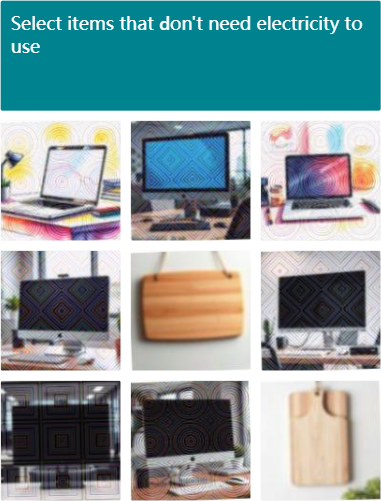

In [87]:
print(challenge_result_image_label_binary.coordinates)
Image(image_label_binary_filepath)

## Spatial Point Reasoning (`IMAGE_LABEL_SINGLE_SELECT`)

In [69]:
job_type = ChallengeTypeEnum.IMAGE_LABEL_SINGLE_SELECT
job_prompt = f"**JobType:** {job_type.value}\nIf you answer correctly, I will reward you with a tip of $20."

image_label_area_select_filepath_1 = Path("assets/image_label_area_select/20250426225911341786_0_challenge_view.png")

completion_image_label_area_select_1 = client.chat.completions.parse(
    model="gpt-5",
    reasoning_effort="minimal",
    messages=build_messages(
        job_prompt,
        image_label_area_select_filepath_1,
        spatial_point_reasoning.THINKING_PROMPT,
    ),
    response_format=spatial_point_reasoning.ImageAreaSelectChallenge,
)
challenge_result_image_label_area_select_1 = completion_image_label_area_select_1.choices[0].message.parsed

JSON(challenge_result_image_label_area_select_1.model_dump())

<IPython.core.display.JSON object>

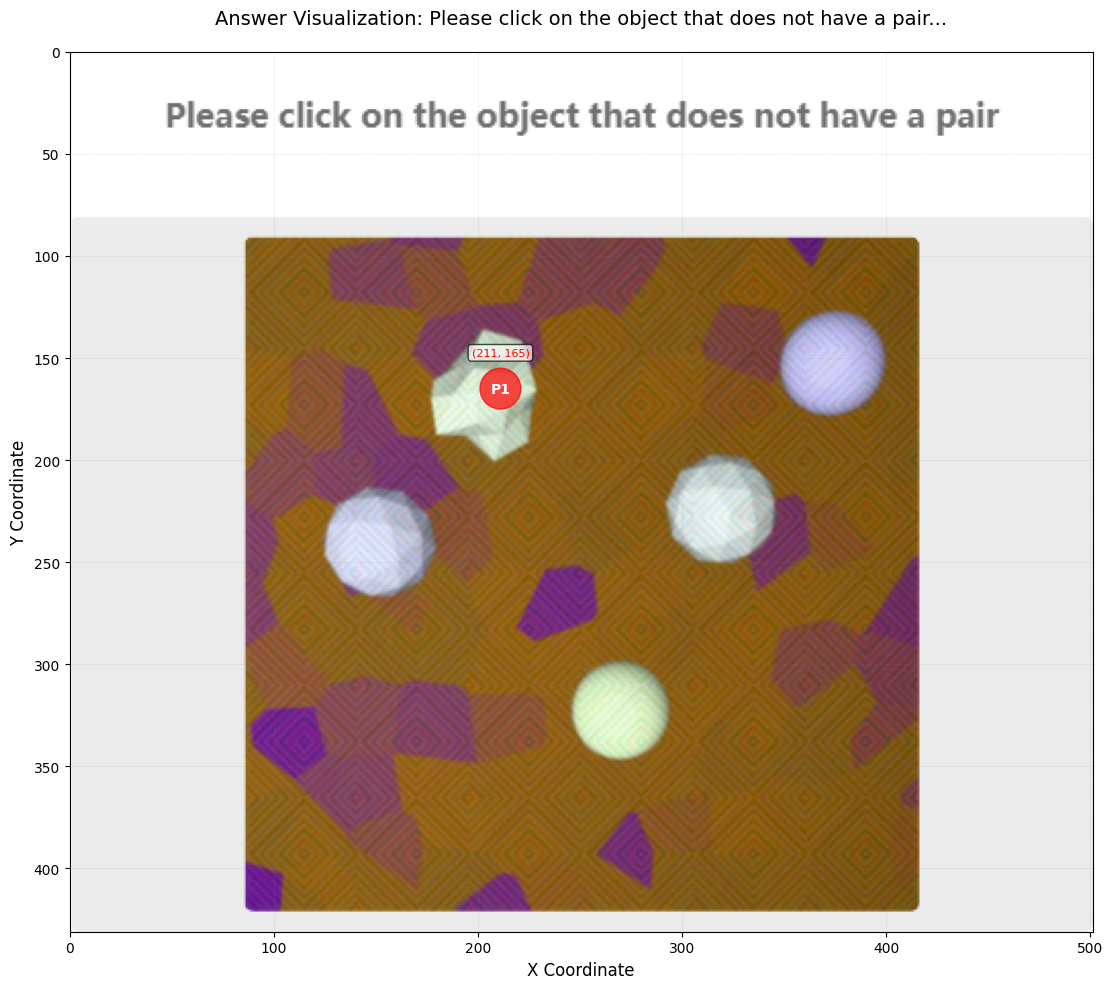

In [70]:
# Visualize the answer on the actual image
result = show_answer_points(
    image_label_area_select_filepath_1,
    challenge_result_image_label_area_select_1,
    DEFAULT_BBOX,
    show_plot=True,
)

## Spatial Point Reasoning (`IMAGE_LABEL_MULTI_SELECT_`)

In [71]:
job_type = ChallengeTypeEnum.IMAGE_LABEL_MULTI_SELECT
job_prompt = f"**JobType:** {job_type.value}\nIf you answer correctly, I will reward you with a tip of $20."

image_label_area_select_filepath_2 = Path("assets/image_label_area_select/20250818003234074379_0_challenge_view.png")

completion_image_label_area_select_2 = client.chat.completions.parse(
    model="gpt-5",
    reasoning_effort="minimal",
    messages=build_messages(
        job_prompt,
        image_label_area_select_filepath_2,
        spatial_point_reasoning.THINKING_PROMPT,
    ),
    response_format=spatial_point_reasoning.ImageAreaSelectChallenge,
)
challenge_result_image_label_area_select_2 = completion_image_label_area_select_2.choices[0].message.parsed

JSON(challenge_result_image_label_area_select_2.model_dump())

<IPython.core.display.JSON object>

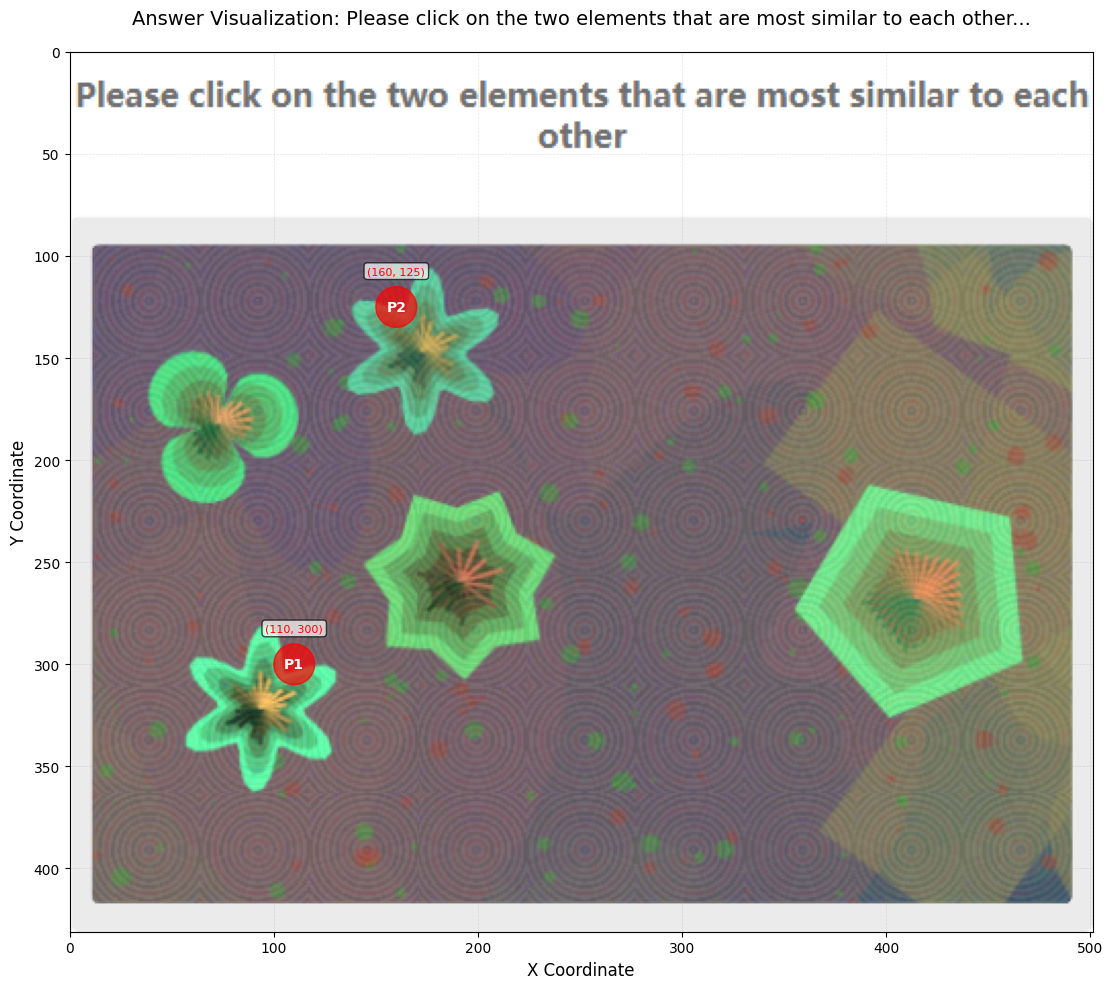

In [72]:
# Visualize the answer on the actual image
result_2 = show_answer_points(
    image_label_area_select_filepath_2,
    challenge_result_image_label_area_select_2,
    DEFAULT_BBOX,
    show_plot=True,
)

## Spatial Path Reasoning (`IMAGE_DRAG_SINGLE`)

In [75]:
job_type = ChallengeTypeEnum.IMAGE_DRAG_SINGLE
job_prompt = f"JobType: {job_type.value}\nIf you answer correctly, I will reward you with a tip of $20."

image_drag_drop_single_single_filepath = Path("assets/image_drag_drop/20250717190455891095_0_challenge_view.png")

completion_image_drag_drop_single = client.chat.completions.parse(
    model="gpt-5",
    reasoning_effort="medium",
    messages=build_messages(
        job_prompt,
        image_drag_drop_single_single_filepath,
        spatial_path_reasoning.THINKING_PROMPT,
    ),
    response_format=spatial_path_reasoning.ImageDragDropChallenge,
)
challenge_result_image_drag_drop_single = completion_image_drag_drop_single.choices[0].message.parsed

JSON(challenge_result_image_drag_drop_single.model_dump())

<IPython.core.display.JSON object>

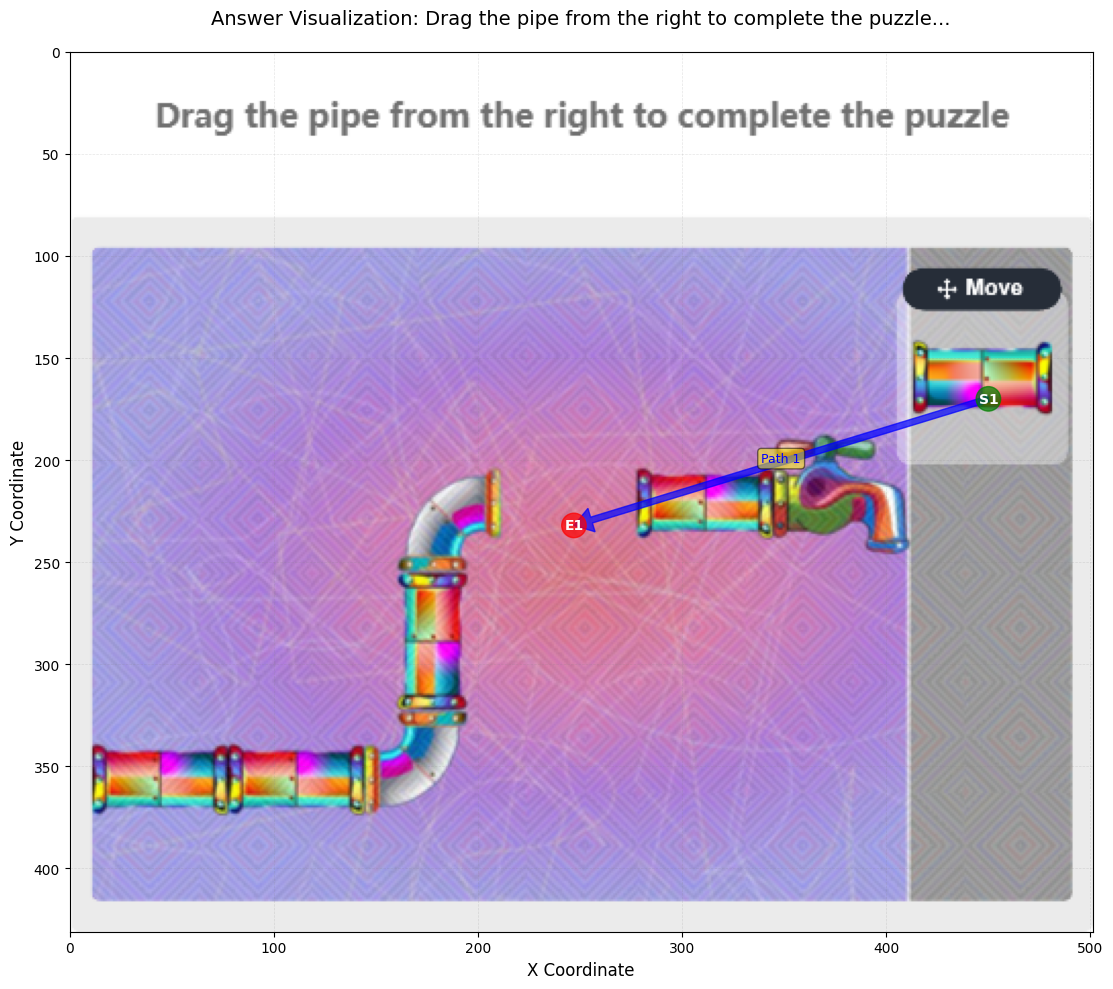

In [76]:
# Visualize the answer on the actual image
result = show_answer_points(
    image_drag_drop_single_single_filepath,
    challenge_result_image_drag_drop_single,
    DEFAULT_BBOX,
    show_plot=True,
    path_color='blue',
    arrow_width=3,
    alpha=0.7
)

## Spatial Path Reasoning (`IMAGE_DRAG_MULTI`)

In [73]:
job_type = ChallengeTypeEnum.IMAGE_DRAG_MULTI
job_prompt = f"JobType: {job_type.value}\nLocate the middle part of the piece, and then infer the drag path."

image_drag_drop_single_multi_filepath = Path("assets/image_drag_drop/20250818003210373861_0_challenge_view.png")

completion_image_drag_drop_multi = client.chat.completions.parse(
    model="gpt-5",
    reasoning_effort="medium",
    messages=build_messages(
        job_prompt,
        image_drag_drop_single_multi_filepath,
        spatial_path_reasoning.THINKING_PROMPT,
    ),
    response_format=spatial_path_reasoning.ImageDragDropChallenge,
)
challenge_result_image_drag_drop_multi = completion_image_drag_drop_multi.choices[0].message.parsed

JSON(challenge_result_image_drag_drop_multi.model_dump())

<IPython.core.display.JSON object>

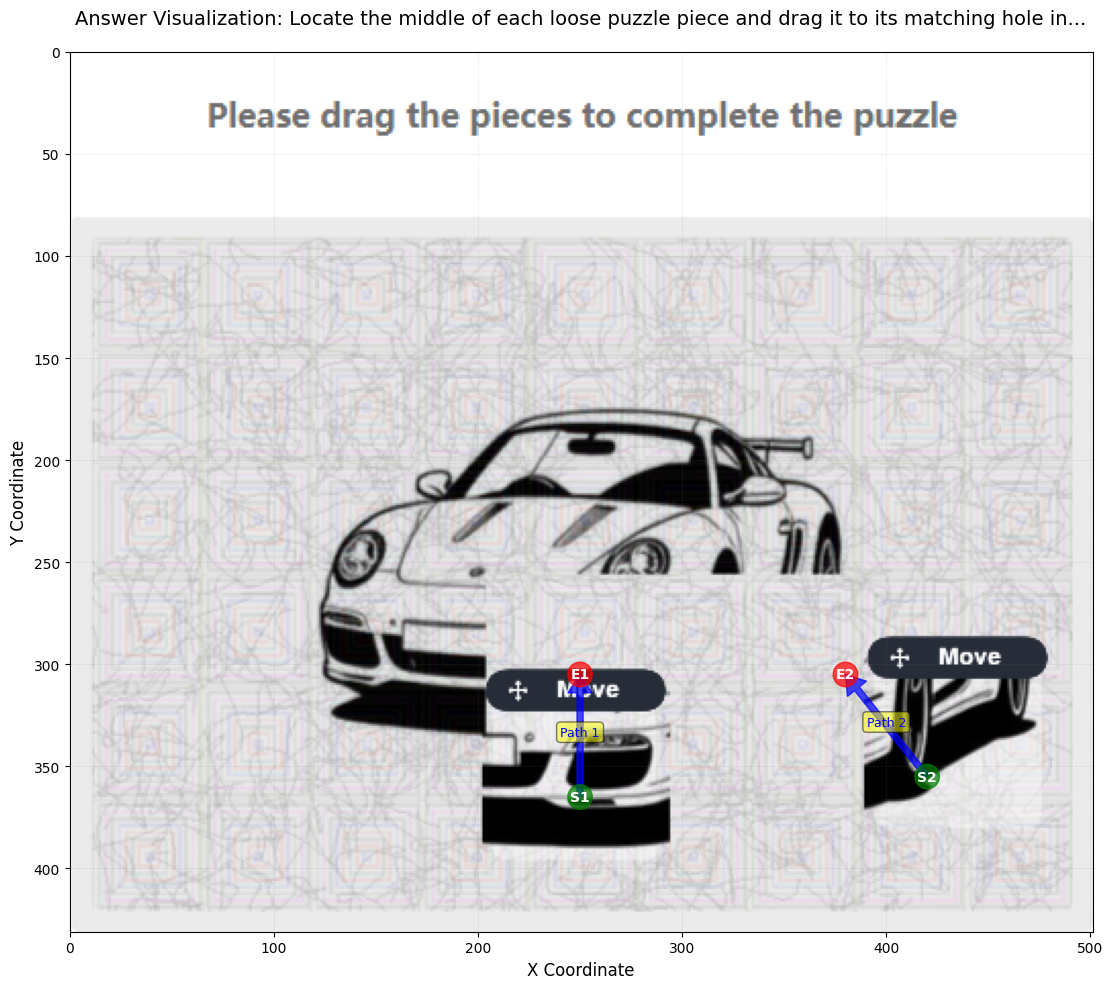

In [74]:
# Visualize the answer on the actual image
result = show_answer_points(
    image_drag_drop_single_multi_filepath,
    challenge_result_image_drag_drop_multi,
    DEFAULT_BBOX,
    show_plot=True,
    path_color='blue',
    arrow_width=3,
    alpha=0.7
)

## Spatial Path Reasoning (`IMAGE_DRAG_MULTI:CHALLENGE`)

In [85]:
job_type = ChallengeTypeEnum.IMAGE_DRAG_MULTI
job_prompt = f"JobType: {job_type.value}\n"

image_drag_drop_single_multi_filepath_2 = Path("assets/image_drag_drop/single_9.png")

completion_image_drag_drop_multi_2 = client.chat.completions.parse(
    model="gpt-5",
    reasoning_effort="medium",
    messages=build_messages(
        job_prompt,
        image_drag_drop_single_multi_filepath_2,
        system_prompt_=None,
    ),
    response_format=spatial_path_reasoning.ImageDragDropChallenge,
)
challenge_result_image_drag_drop_multi_2 = completion_image_drag_drop_multi_2.choices[0].message.parsed

JSON(challenge_result_image_drag_drop_multi_2.model_dump())

<IPython.core.display.JSON object>

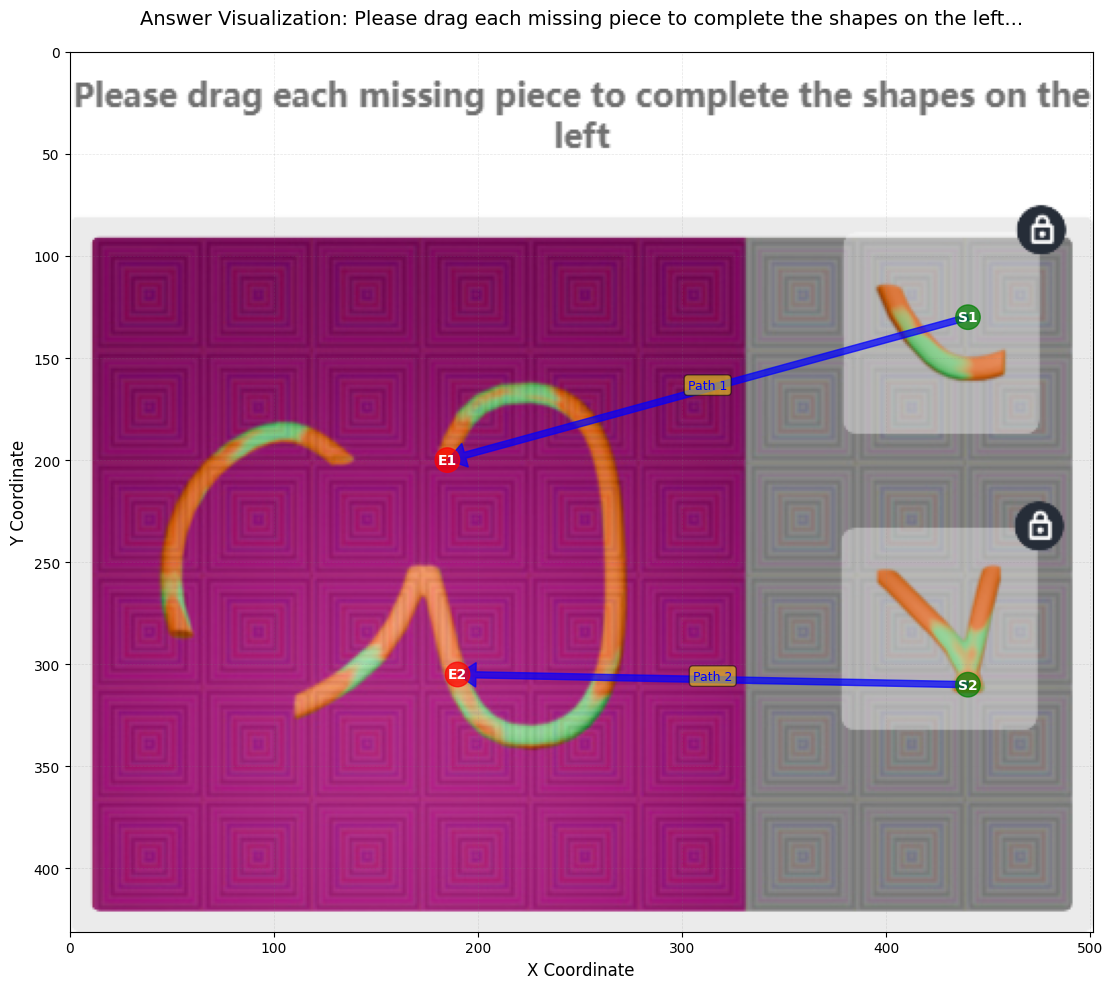

In [86]:
# Visualize the answer on the actual image
result = show_answer_points(
    image_drag_drop_single_multi_filepath_2,
    challenge_result_image_drag_drop_multi_2,
    DEFAULT_BBOX,
    show_plot=True,
    path_color='blue',
    arrow_width=3,
    alpha=0.7
)